In [1]:
# Load Libraries

import os
import sys
import joblib
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima



In [2]:
import os, sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

# Sanity check
print("Root in sys.path:", project_root in sys.path)
print("Resolved project root:", project_root)


Root in sys.path: True
Resolved project root: C:\Users\user\Documents\AI_projects\AirQualityPrediction_Lagos


In [3]:
from scripts.wrangle import wrangle, merge_monthly_files, load_combined_series
from scripts.model_training import train_sarima_model, save_model, load_latest_model, forecast_with_model
from scripts.evaluate import evaluate_forecast, plot_forecast
from scripts.validate import load_latest_wfv_results, main


In [4]:
# wrangle data
filepath = "../data/monthly_p2_readings/2023_11.csv"

df = wrangle(filepath=filepath)
df.head()

,sensor_id,sensor_type,location,lat,lon,value_type,PM2.5
date,,,,,,,
2023-11-01 17:44:52.764459+01:00,4855,pms5003,3629,6.428,3.435,P2,19.00
2023-11-01 18:52:08.924982+01:00,4857,pms5003,3630,6.540,3.297,P2,3.50
2023-11-01 18:53:13.805911+01:00,4857,pms5003,3630,6.540,3.297,P2,3.00
2023-11-01 19:16:42.515782+01:00,4853,pms5003,3628,6.559,3.386,P2,40.33
2023-11-03 08:38:39.664224+01:00,4857,pms5003,3630,6.540,3.297,P2,47.00


In [4]:
# Cimbine multiple datasets

merge_monthly_files().head()

Reading files from: C:\Users\user\Documents\AI_projects\AirQualityPrediction_Lagos\data/monthly_p2_readings/
Processed 2023_11.csv
Processed 2023_12.csv
Processed 2024_01.csv
Processed 2024_02.csv
Processed 2024_03.csv
Processed 2024_04.csv
Processed 2024_05.csv
Processed 2024_06.csv
Processed 2024_07.csv
Processed 2024_08.csv
Processed 2024_09.csv
Processed 2024_10.csv
Processed 2024_11.csv
Processed 2024_12.csv
Processed 2025_01.csv
Processed 2025_02.csv
Processed 2025_03.csv
Processed 2025_04.csv

Combined shape: (73601, 7)


,sensor_id,sensor_type,location,lat,lon,value_type,PM2.5
date,,,,,,,
2023-11-01 17:44:52.764459+01:00,4855,pms5003,3629,6.428,3.435,P2,19.00
2023-11-01 18:52:08.924982+01:00,4857,pms5003,3630,6.540,3.297,P2,3.50
2023-11-01 18:53:13.805911+01:00,4857,pms5003,3630,6.540,3.297,P2,3.00
2023-11-01 19:16:42.515782+01:00,4853,pms5003,3628,6.559,3.386,P2,40.33
2023-11-03 08:38:39.664224+01:00,4857,pms5003,3630,6.540,3.297,P2,47.00


In [8]:
# Load Combined dataset into dataframe
train, test = load_combined_series()

print(f"Train split: {train.shape}")
print(f"Test split: {test.shape}")

Train split: (1654,)
Test split: (414,)


In [5]:
y = train

# PM2.5 Over time
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(y)
plt.title("PM2.5 Values over Time")
plt.xlabel("Years")
plt.ylabel("PM2.5")
plt.show()

window = 120
# rolling mean for 30 days or 720 hours
rolling_mean = y.rolling(window= window).mean()

# rolling variance for 30 days or 720 hours
rolling_std = y.rolling(window = window).std()

# Plot charts
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(rolling_mean, label = "Rolling mean 30d")
plt.plot(rolling_std, label = "Rolling std 30d")
plt.title("Rolling Average and Standard Deviation over 30 days or 720 hours")
plt.xlabel("Years")
plt.ylabel("PM2.5")

plt.legend()
plt.show()

# Figure size
plt.figure(figsize= (15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins =  30, color= "skyblue")
plt.title("PM2.5 Distribution")
plt.ylabel("Frequency [count]")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y, color= "lightcoral", orient="h")
plt.title("PM2.5 Boxplot: There appears to be Outliers")
plt.ylabel("Frequency [count]")

plt.show()

period = 120

# Instantiate the seasonal_decompose
decomposition = seasonal_decompose(y, model="additive", period=period)

# Plot the Chart
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Additive Model)", fontsize=14)
plt.tight_layout()
plt.show()

# plot_acf

fig, ax = plt.subplots(figsize=(14, 5))
plot_acf(y, ax=ax)
plt.title("Autocorrelation (ACF)")
plt.tight_layout()
plt.show()

# plot_pacf

fig, ax = plt.subplots(figsize=(14, 5))
plot_pacf(y, ax=ax)
plt.title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

NameError: name 'train' is not defined

# testing the created Scripts

In [10]:
# train model
model = train_sarima_model()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  PM2.5   No. Observations:                 1654
Model:             SARIMAX(3, 1, 1)x(2, 0, [1, 2], 4)   Log Likelihood               -6002.096
Date:                                Sat, 07 Jun 2025   AIC                          12022.193
Time:                                        11:45:35   BIC                          12070.826
Sample:                                    11-01-2023   HQIC                         12040.228
                                         - 12-18-2024                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8268      0.016     50.277      0.000       0.795       0.859
ar.L2         -0.0364      0.026     -1.397      0.163      -0.087       0.015
ar.L3         -0.0059      0.022     -0.266      0.790      -0.049       0.037
ma.L1         -0.9941      0.004   -268.317      0.000      -1.001      -0.987
ar.S.L4        0.3839      0.139      2.768      0.006       0.112       0.656
ar.S.L8        0.5757      0.136      4.223      0.000       0.309       0.843
ma.S.L4       -0.3306      0.150     -2.202      0.028      -0.625      -0.036
ma.S.L8       -0.4377      0.132     -3.328      0.001      -0.695      -0.180
sigma2        86.9037      1.441     60.319      0.000      84.080      89.727
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7480.19
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# save_model
save_model(model)

Model saved to models/2025-06-07T09-55-38_sarima_model.pkl


In [4]:
# load model
model = load_latest_model()
print(type(model))

Loaded model: 2025-06-07T11-41-08_sarima_model.pkl
<class 'statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper'>


In [5]:
# forecast
y_pred = forecast_with_model(model)
y_pred.head()

2024-12-19 00:00:00+01:00    51.580966
2024-12-19 06:00:00+01:00    50.870392
2024-12-19 12:00:00+01:00    50.740045
2024-12-19 18:00:00+01:00    51.082686
2024-12-20 00:00:00+01:00    50.828044
Freq: 6h, Name: predicted_mean, dtype: float64

In [8]:
from scripts.config import load_config
cfg = load_config()
print("Resolved results folder:", cfg["paths"]["results_folder"])


Resolved results folder: C:\Users\user\Documents\AI_projects\AirQualityPrediction_Lagos\results/


In [6]:
# loading latest Walk forward validation file
wfv_df = load_latest_wfv_results()

wfv_df.head()

Loaded WFV results: 2025-06-07T11-41-08_walk_forward_results.csv


,y_test,y_pred
date,,
2024-12-19 00:00:00+01:00,52.919605,51.253834
2024-12-19 06:00:00+01:00,53.500504,51.664976
2024-12-19 12:00:00+01:00,54.081404,53.098212
2024-12-19 18:00:00+01:00,54.662303,54.018747
2024-12-20 00:00:00+01:00,55.243202,53.447990


MSE: 42.62943149854451
MAE: 3.44412067444524


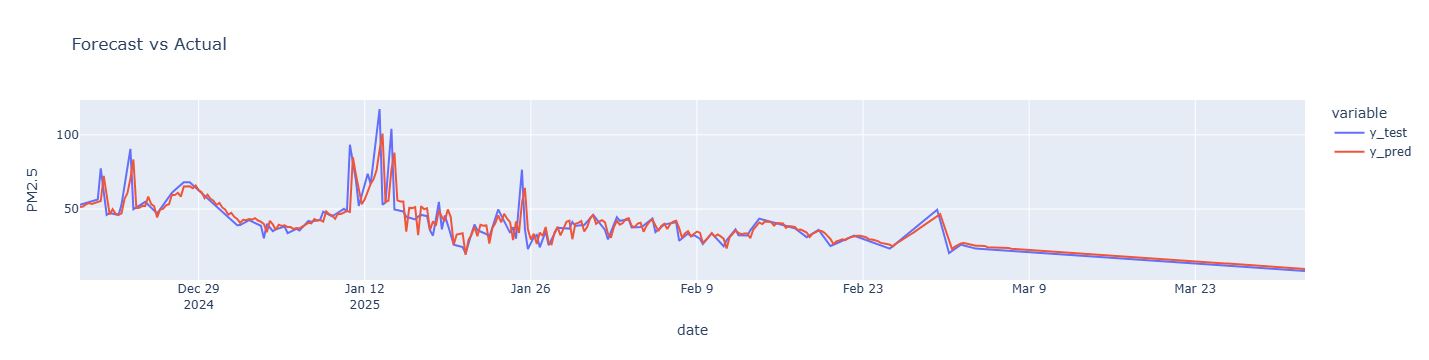

In [9]:
# Evaluate model

mse, mae = evaluate_forecast(test, wfv_df["y_pred"])

print(f"MSE: {mse}")
print(f"MAE: {mae}")

# plot Evaluation

plot_forecast(test, wfv_df["y_pred"])